In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

import shap
from shap import Explanation

from cfshap.utils import attrdict
from cfshap.utils.preprocessing import EfficientQuantileTransformer
from cfshap.counterfactuals import KNNCounterfactuals
from cfshap.attribution import TreeExplainer, CompositeExplainer
from cfshap.trend import TrendEstimator

/home/ubuntu/anaconda3/envs/tempcfshap/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Dataset & Model

Let's load some toy data.

In [ ]:
dataset = load_boston()
X = dataset.data
y = (dataset.target > 21).astype(int)

Let's train a very simple XGB model.

In [3]:
# NOTE: The model must implement `predict`, `predict_proba`, and `get_booster` methods.
model = XGBClassifier(use_label_encoder=False)
model.fit(X, y)

[11:27:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Let's evaluate the model.

In [4]:
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       257

    accuracy                           1.00       506
   macro avg       1.00      1.00      1.00       506
weighted avg       1.00      1.00      1.00       506



## CF-SHAP Explanations

The following example shows how to use the package to generate the feature importance explanations with 100-NN as counterfactual generator and the SHAP TreeExplainer as feature importance estimator.

#### Setup

Let's setup the explainers.

In [5]:
MAX_SAMPLES = 10000

# We will need a scaler in the input space for the counterfactual generator
scaler = EfficientQuantileTransformer()
scaler.fit(X)

# Background/Counterfactuals generator
background_generator = KNNCounterfactuals(
    model=model,
    X=X,
    n_neighbors=100,
    distance='cityblock',
    scaler=scaler,
    max_samples=MAX_SAMPLES,
)

# We will need a trend estimator for the attribution estimator
trend_estimator = TrendEstimator(strategy='mean')

# Feature importance estimator
importance_estimator = TreeExplainer(
    model,
    data=None,
    trend_estimator=trend_estimator,
    max_samples=MAX_SAMPLES,
)

# Let's setup the explainer
cfshap_explainer = CompositeExplainer(
    background_generator,
    importance_estimator,
)

#### Explain

Let's compute the (local) explanations for all the examples in the dataset.

Note that to generate the explanations we can use the `explainer` object as a callable.

In [6]:
explanations = cfshap_explainer(X)

506it [00:01, 504.19it/s]


In [7]:
list(explanations.keys())

['backgrounds', 'values', 'trends']

The `explanations` object will contain:
- The (Counterfactual) SHAP values (`explanations.values`)
- The induced trends from the counterfactuals (`explanations.trends`).
- The counterfactuals that have been used as background for each of the query instances (`explanations.backgrounds`)

Let's now look at the Shapley values:

In [8]:
pd.DataFrame(explanations.values, columns = dataset.feature_names).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.368411,0.001084,0.016953,0.000066,-0.071173,4.944348,0.451436,0.599951,-0.124420,0.468224,2.566800,0.262139,4.089339
1,-0.688685,0.025537,0.117732,-0.005397,0.482204,4.693255,-0.375660,0.659881,-0.073497,0.737982,2.195861,0.174194,1.450351
2,-0.620587,0.052311,0.077167,-0.000131,0.274878,5.873381,0.460579,0.618844,-0.067338,0.596424,1.719293,1.094380,3.774376
3,-0.564064,0.052311,-0.024788,-0.000697,-0.027789,6.080283,1.029735,0.026832,-0.094110,0.537722,0.824205,0.410816,4.969478
4,0.184132,0.040598,-0.017089,-0.000951,-0.041633,6.125439,1.021442,-0.010025,-0.098910,0.545943,0.753446,0.025192,5.016416


and the trends ($+1$ and $-1$ mean to, respectively, increase and decrease the feature).

In [9]:
pd.DataFrame(explanations.trends, columns = dataset.feature_names).astype(int).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1,-1,1,1,-1,-1,1,1,1,1,1,-1,1
1,1,1,1,1,1,-1,-1,-1,1,1,1,-1,1
2,1,1,1,1,1,-1,1,-1,1,1,1,-1,1
3,1,1,1,1,1,-1,1,-1,1,1,1,-1,1
4,1,1,1,1,1,-1,1,-1,1,1,1,-1,1


### Plot

We can use the plotting functionalities of the `shap` library also to plot the Counterfactual SHAP values.

First, let's compute the base values for each of the query intances.

NOTE: Differently from `shap`, `cf-shap` explanations have a base value __for each query instance__ because the background distribution used to compute the explanation is not static.

In [10]:
# We use output_margin = True, becasue Shapley values for XGBoost models are computed over the log-odds output (a.k.a., margin)
base_values = np.array([model.predict(X_background, output_margin=True).mean() for X_background in explanations.backgrounds])

#### Local Explanation (for a single query instance)

Let's plot the waterfall plot for the first (local) explanation.

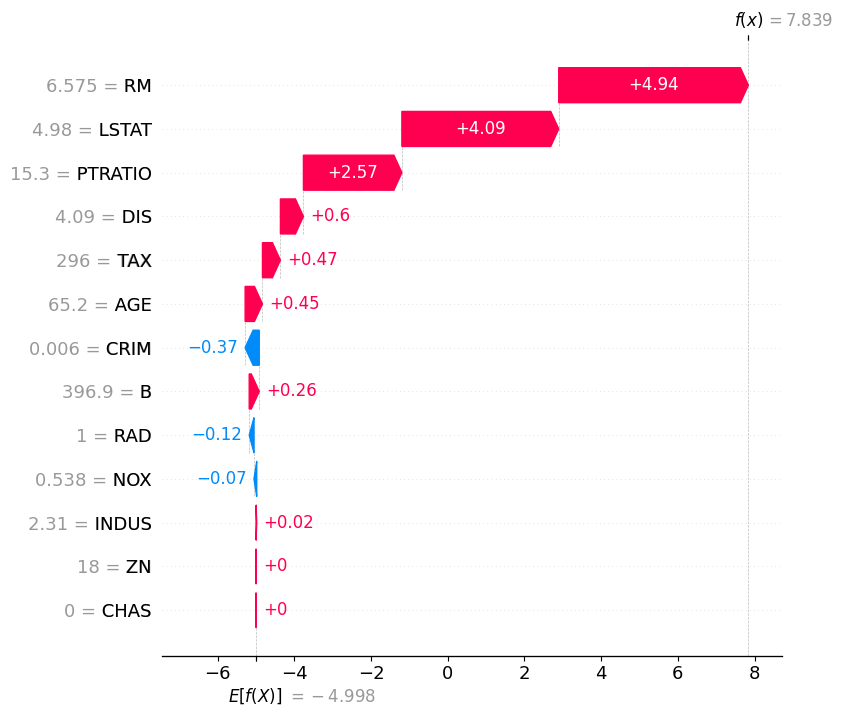

In [11]:
local_explanation = attrdict(
    values=explanations.values[0],
    base_values=base_values[0],
    feature_names=dataset.feature_names,
    data=X[0],
)

shap.plots.waterfall(local_explanation, max_display=15)

#### Global Explanation (for all the query instances)

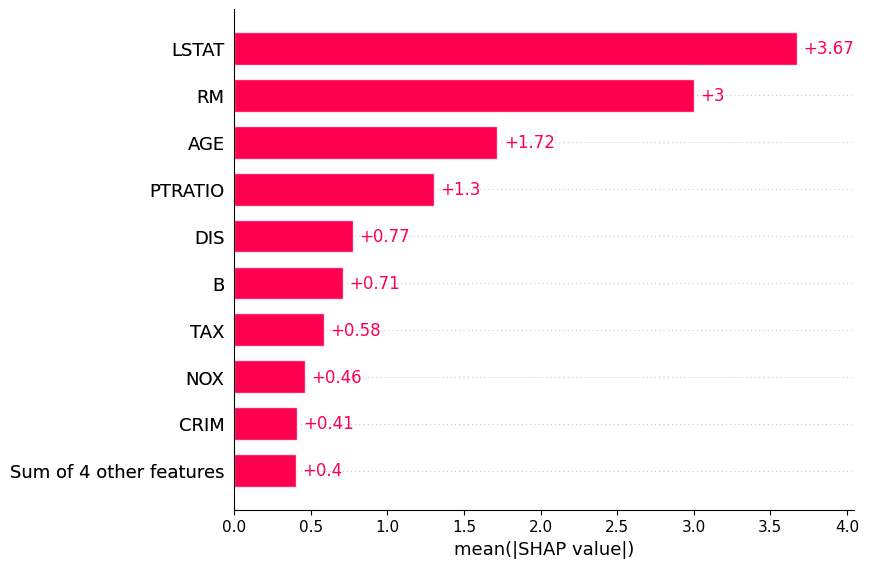

In [12]:
global_explanation = Explanation(
    values=explanations.values,
    feature_names=dataset.feature_names,
)

shap.plots.bar(global_explanation)